In [1]:
import os
import time
import sys
import json
import numpy as np
import ipyvolume as ipv
from pathlib import Path
import pandas as pd
import random
from datetime import datetime

from tyssue import Sheet, config
from tyssue.io import hdf5
from tyssue.generation import ellipsoid_sheet
from tyssue.draw.ipv_draw import view_ipv
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.dynamics import effectors, units
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.topology.sheet_topology import remove_face
from tyssue.utils.decorators import do_undo
from tyssue.utils import to_nd
from tyssue.io import hdf5
from tyssue import SheetGeometry as geom

import matplotlib.pyplot as plt

%matplotlib inline

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')


In [2]:
class LineTension(effectors.AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "Line tension"
    element = "edge"
    specs = {"edge": {"is_active", "line_tension", "polarity"}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length" "* polarity"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt

In [3]:
class Polarity(effectors.AbstractEffector):
    
    dimensions = units.line_tension
    magnitude = 'polarity'
    label = 'apical polarity'
    element = {'edge'}
    specs = {'edge':{'N_a', 'length'}}

    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            'length * N_a')
         
    @staticmethod
    def gradient(eptm):
        grad = height_grad(eptm) * to_nd(
            eptm.vert_df.eval('radial_tension'), 3)
        grad.columns = ['g'+c for c in eptm.coords]
        return grad, None
    
    


In [4]:
EllipsoidBModel = model_factory(
    [
    #Polarity,
    #LineTension,
    effectors.FaceContractility,
    effectors.FaceVolumeElasticity,
    ], effectors.FaceAreaElasticity)

model = EllipsoidBModel


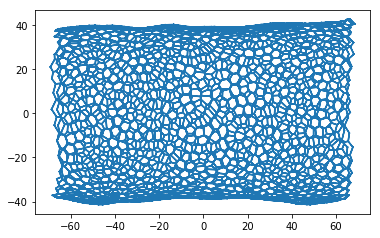

In [5]:
dsets = hdf5.load_datasets('../../tyssue/doc/examples/before_apoptosis.hf5',
                           data_names=['vert', 'edge', 'face'])


specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', dsets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('zx'))

In [6]:
# Add column 'N' to face_df, which contains the total quantity of protein a in the cell
sheet.face_df['N_a'] = 1

# Add column 'N' to edge_df, whoch contains the quantity of protein along one edge
sheet.edge_df['N_a'] = 0
for e in sheet.edge_df.index :
    sheet.edge_df.loc[e, 'N_a'] = 1/sheet.face_df.loc[sheet.edge_df.loc[e,'face'], 'num_sides']  

In [19]:
sheet.edge_df['N_a'] = 1/sheet.face_df.loc[sheet.edge_df['face'], 'num_sides']

ValueError: cannot reindex from a duplicate axis

In [17]:
from tyssue import config
from scipy import optimize
from scipy.sparse import coo_matrix
        
def find_energy_min(cls, sheet, geom, model, pos_idx=None, **settings_kw):
    # Loads 'tyssue/config/solvers/minimize.json
    settings = config.solvers.minimize_spec()
    settings.update(**settings_kw)

    pos0 = sheet.edge_df[coords].values


    row = sheet.edge_df['face'].values
    col = sheet.edge_df.index.values
    matrix = coo_matrix((np.ones(sheet.Ne), (row, col)), shape=(sheet.Nf, sheet.Ne)).toarray()

    linear_constraint = optimize.LinearConstraint(matrix, sheet.face_df['N_a'], sheet.face_df['N_a'])

    res = optimize.minimize(
        cls.opt_energy, 
        sheet.edge_df['N_a'],
        #bounds=bounds,
        constraints=linear_constraint,
        jac=cls.opt_grad,
        **settings["minimize"]
    )
    return res

    
def chem_energy(sheet, geom, model):
    """Need to be completed"""

    C1_ij = sheet.edge_df.sort_values(['face', 'trgt'])['N_a'].values / sheet.edge_df.sort_values(['face', 'trgt'])['length'].values
    C1_jm = sheet.edge_df.sort_values(['face', 'srce'])['N_a'].values / sheet.edge_df.sort_values(['face', 'srce'])['length'].values

    C2_ij = sheet.edge_df.sort_values(['face', 'srce'])['N_a'].values / sheet.edge_df.sort_values(['face', 'srce'])['length'].values
    C2_ni = sheet.edge_df.sort_values(['face', 'trgt'])['N_a'].values / sheet.edge_df.sort_values(['face', 'trgt'])['length'].values
    
    
    Fp = - J/2 * ((C1_ij - C1_jm)**2 + (C2_ij - C2_ni)**2)
    
    return model.compute_energy(sheet, full_output=False)
    
    
    
def chem_grad():
    return

In [233]:
from tyssue.utils import data_at_opposite

epsilon_0 = 1
epsilon_1 = 1
J=1

#Part1
P1 = (- epsilon_0/2 * sheet.edge_df['length'] * (sheet.edge_df['N_a'] / sheet.edge_df['length'])**2).values

#Part2
sheet.get_opposite()
P2 = (- epsilon_1 * sheet.edge_df['N_a'] * data_at_opposite(sheet, sheet.edge_df.N_a) / sheet.edge_df['length']).values

#Part 3
C1_ij = sheet.edge_df.sort_values(['face', 'trgt'])['N_a'].values / sheet.edge_df.sort_values(['face', 'trgt'])['length']
C1_jm = sheet.edge_df.sort_values(['face', 'srce'])['N_a'].values / sheet.edge_df.sort_values(['face', 'srce'])['length']
couple1 = pd.DataFrame({'ij':C1_ij.values, 'jm':C1_jm.values}, index=C1_ij.index)
diff_couple1 = couple1['ij']-couple1['jm']
diff_couple1.sort_index(axis='index', inplace=True)

C2_ij = sheet.edge_df.sort_values(['face', 'srce'])['N_a'].values / sheet.edge_df.sort_values(['face', 'srce'])['length']
C2_ni = sheet.edge_df.sort_values(['face', 'trgt'])['N_a'].values / sheet.edge_df.sort_values(['face', 'trgt'])['length']
couple2 = pd.DataFrame({'ij':C2_ij.values, 'ni':C2_ni.values}, index=C2_ij.index)
diff_couple2 = couple2['ij']-couple2['ni']
diff_couple2.sort_index(axis='index', inplace=True)

P3 = - J/2 * ( (diff_couple1)**2 + (diff_couple2)**2 )
  


Fp = (P1 + P2 + P3).sum()

print(Fp)

-780398826.8327409


/home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3rc1-py3.6-linux-x86_64.egg/tyssue/core/sheet.py:369: UserWarning: Duplicated (`srce`, `trgt`) values in edge_df, maybe sanitize your input
  "Duplicated (`srce`, `trgt`) values in edge_df, maybe sanitize your input"


In [18]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                          'options': {'ftol': 1e-8,
                                      'gtol': 1e-8}}}
solver = SolverPolarity
res = solver.find_energy_min(sheet, geom, model, **solver_kw)

/home/admin-suz/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:520: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  RuntimeWarning)


ValueError: cannot reshape array of size 10118 into shape (3372,3)